In [31]:
import pandas as pd

In [32]:
df = pd.read_csv('/content/modified_ais_data.csv',nrows=1000)

In [33]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG
0,2022-03-31T00:00:01,671226100,IMO9221322,25.77626,-80.20320,3.2,143.7
1,2022-03-31T00:00:06,367452810,IMO9602344,29.32824,-94.77391,2.6,319.2
2,2022-03-31T00:00:09,366919770,IMO9253583,48.74428,-122.49504,0.0,210.3
3,2022-03-31T00:00:00,311000966,IMO8916607,18.55833,-66.47910,17.5,274.5
4,2022-03-31T00:00:01,219028420,IMO9411305,28.66703,-93.59339,9.5,129.4


In [34]:
import math

def lat_lon_to_cartesian(lat, lon, R=6371):
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    x = R * math.cos(lat_rad) * math.cos(lon_rad)
    y = R * math.cos(lat_rad) * math.sin(lon_rad)
    z = R * math.sin(lat_rad)
    return x, y, z

def cartesian_to_lat_lon(x, y, z, R=6371):
    lon = math.degrees(math.atan2(y, x))
    lat = math.degrees(math.asin(z / R))
    return lat, lon


In [35]:
df[['x', 'y', 'z']] = df.apply(lambda row: pd.Series(lat_lon_to_cartesian(row['LAT'], row['LON'])), axis=1)

In [36]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z
0,2022-03-31T00:00:01,671226100,IMO9221322,25.77626,-80.20320,3.2,143.7,976.189651,-5653.417795,2770.480464
1,2022-03-31T00:00:06,367452810,IMO9602344,29.32824,-94.77391,2.6,319.2,-462.261129,-5535.146877,3120.593645
2,2022-03-31T00:00:09,366919770,IMO9253583,48.74428,-122.49504,0.0,210.3,-2256.980451,-3543.426543,4789.552023
3,2022-03-31T00:00:00,311000966,IMO8916607,18.55833,-66.47910,17.5,274.5,2410.348516,-5537.896973,2027.697745
4,2022-03-31T00:00:01,219028420,IMO9411305,28.66703,-93.59339,9.5,129.4,-350.359001,-5579.067584,3056.287693


In [37]:
import numpy as np
def haversine(lat1, lon1, lat2, lon2, R=6371):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [38]:
df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"])

In [39]:
def calculate_distances(group):
    group = group.sort_values(by="BaseDateTime")
    group["next_lat"] = group["LAT"].shift(-1)
    group["next_long"] = group["LON"].shift(-1)
    group["distance_km"] = group.apply(
        lambda row: haversine(row["LAT"], row["LON"], row["next_lat"], row["next_long"])
        if not np.isnan(row["next_lat"])
        else 0,
        axis=1,
    )
    return group.drop(columns=["next_lat", "next_long"])

In [40]:
df = df.groupby("MMSI").apply(calculate_distances).reset_index(drop=True)
df.head()

<ipython-input-40-e18fd20cbb70>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("MMSI").apply(calculate_distances).reset_index(drop=True)


,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km
0,2022-03-31 00:00:17,1056261,IMO1056261,26.11809,-80.14815,0.1,220.5,978.775466,-5636.091653,2804.658708,0.000000
1,2022-03-31 00:01:13,209136000,IMO9416707,45.64101,-122.74869,0.0,218.5,-2409.574733,-3746.291746,4555.094813,0.000000
2,2022-03-31 00:00:01,209513000,IMO9060247,26.09387,-80.08081,28.3,272.6,985.603053,-5636.104757,2802.240317,0.563219
3,2022-03-31 00:01:03,209513000,IMO9060247,26.09386,-80.08645,14.9,269.4,985.048333,-5636.202230,2802.239319,0.000000
4,2022-03-31 00:00:00,209613000,IMO9266542,29.80067,-79.81317,10.6,186.0,977.761677,-5441.347041,3166.285755,0.000000


In [41]:
def calculate_durations(group):
    # Ensure BaseDateTime is a datetime type
    group['BaseDateTime'] = pd.to_datetime(group['BaseDateTime'])
    # Calculate the duration between consecutive points in seconds
    group['duration_seconds'] = group['BaseDateTime'].diff().dt.total_seconds()
    return group

In [42]:
df = df.groupby("MMSI", group_keys=False).apply(calculate_durations)
df = df.reset_index(drop=True)
df.head()

<ipython-input-42-1fbd24d56e1c>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("MMSI", group_keys=False).apply(calculate_durations)


,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km,duration_seconds
0,2022-03-31 00:00:17,1056261,IMO1056261,26.11809,-80.14815,0.1,220.5,978.775466,-5636.091653,2804.658708,0.000000,NaN
1,2022-03-31 00:01:13,209136000,IMO9416707,45.64101,-122.74869,0.0,218.5,-2409.574733,-3746.291746,4555.094813,0.000000,NaN
2,2022-03-31 00:00:01,209513000,IMO9060247,26.09387,-80.08081,28.3,272.6,985.603053,-5636.104757,2802.240317,0.563219,NaN
3,2022-03-31 00:01:03,209513000,IMO9060247,26.09386,-80.08645,14.9,269.4,985.048333,-5636.202230,2802.239319,0.000000,62.0
4,2022-03-31 00:00:00,209613000,IMO9266542,29.80067,-79.81317,10.6,186.0,977.761677,-5441.347041,3166.285755,0.000000,NaN


In [43]:
# Define constants
KNOTS_TO_METERS_PER_SEC = 0.514444
df['sog_mps'] = df['SOG'].apply(lambda x: x * KNOTS_TO_METERS_PER_SEC)
df['cog_radians'] = df['COG'].apply(lambda x: np.radians(x))


In [44]:
df = df[['x','y','z','duration_seconds','distance_km','sog_mps','cog_radians']]

In [45]:
df.head()

,x,y,z,duration_seconds,distance_km,sog_mps,cog_radians
0,978.775466,-5636.091653,2804.658708,NaN,0.000000,0.051444,3.848451
1,-2409.574733,-3746.291746,4555.094813,NaN,0.000000,0.000000,3.813544
2,985.603053,-5636.104757,2802.240317,NaN,0.563219,14.558765,4.757768
3,985.048333,-5636.202230,2802.239319,62.0,0.000000,7.665216,4.701917
4,977.761677,-5441.347041,3166.285755,NaN,0.000000,5.453106,3.246312


In [46]:
df.dropna(inplace=True)

<ipython-input-46-c64f9f573c18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [47]:
df.head()

,x,y,z,duration_seconds,distance_km,sog_mps,cog_radians
3,985.048333,-5636.202230,2802.239319,62.0,0.0,7.665216,4.701917
8,1038.813807,-5617.560112,2820.199507,66.0,0.0,7.459438,0.713840
28,964.816679,-5298.686551,3403.335218,69.0,0.0,5.813217,4.066617
32,945.221036,-5275.068348,3445.265174,69.0,0.0,6.173328,2.089159
48,1043.049048,-5653.562549,2745.709415,61.0,0.0,6.276217,3.267256


# attention (en+de)

X_train shape: (72, 10, 3)
decoder_inputs_train shape: (72, 9, 3)
decoder_targets_train shape: (72, 9, 3)
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 278ms/step - accuracy: 0.3441 - loss: 0.5945 - val_accuracy: 0.3457 - val_loss: 0.5447
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3539 - loss: 0.4663 - val_accuracy: 0.3704 - val_loss: 0.4743
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3825 - loss: 0.3875 - val_accuracy: 0.3827 - val_loss: 0.4042
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3890 - loss: 0.3127 - val_accuracy: 0.3704 - val_loss: 0.3299
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3901 - loss: 0.2627 - val_accuracy: 0.3580 - val_loss: 0.2626
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4131 - loss: 0.2098 - val_accuracy: 0.3395 - val_loss: 0.2108
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3977 - loss: 0.1717 - val_accuracy: 0.3642 - val_loss: 0.1753
Epoch 8/50
5/5 ━━

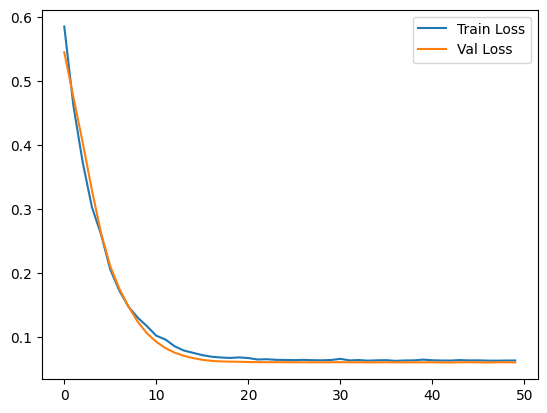

In [70]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, Flatten
)
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

\
# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Function to create time-series sequences
def create_sequences(data, seq_length):
    X, decoder_inputs, decoder_targets = [], [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Encoder input: Full sequence
        decoder_inputs.append(data[i+1:i+seq_length])  # Decoder input (shifted left)
        decoder_targets.append(data[i+2:i+seq_length+1])  # Decoder targets (shifted left again)
    return np.array(X), np.array(decoder_inputs), np.array(decoder_targets)

seq_length = 10  # Look at last 10 time steps
X, decoder_inputs, decoder_targets = create_sequences(scaled_data, seq_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, decoder_inputs_train, decoder_targets_train = X[:train_size], decoder_inputs[:train_size], decoder_targets[:train_size]
X_test, decoder_inputs_test, decoder_targets_test = X[train_size:], decoder_inputs[train_size:], decoder_targets[train_size:]

# Print shapes
print("X_train shape:", X_train.shape)  # (num_samples, seq_length, num_features)
print("decoder_inputs_train shape:", decoder_inputs_train.shape)  # (num_samples, seq_length-1, num_features)
print("decoder_targets_train shape:", decoder_targets_train.shape)  # (num_samples, seq_length-1, num_features)

# Transformer Encoder Block
def transformer_encoder(inputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
    input_dim = tf.keras.backend.int_shape(inputs)[-1]
    key_dim = max(1, input_dim // num_heads)

    attention_norm = LayerNormalization(epsilon=1e-6)(inputs)
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(attention_norm, attention_norm)
    attention = Dropout(dropout_rate)(attention)
    attention = inputs + attention
    attention = LayerNormalization(epsilon=1e-6)(attention)

    ff_output = Dense(ff_dim, activation="relu")(attention)
    ff_output = Dense(input_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)

    return LayerNormalization(epsilon=1e-6)(attention + ff_output)

# Transformer Decoder Block
def transformer_decoder(inputs, encoder_outputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
    input_dim = tf.keras.backend.int_shape(inputs)[-1]
    key_dim = max(1, input_dim // num_heads)

    attention_norm = LayerNormalization(epsilon=1e-6)(inputs)
    attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(attention_norm, attention_norm)
    attention1 = Dropout(dropout_rate)(attention1)
    attention1 = inputs + attention1
    attention1 = LayerNormalization(epsilon=1e-6)(attention1)

    attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
        query=attention1, key=encoder_outputs, value=encoder_outputs
    )
    attention2 = Dropout(dropout_rate)(attention2)
    attention2 = attention1 + attention2
    attention2 = LayerNormalization(epsilon=1e-6)(attention2)

    ff_output = Dense(ff_dim, activation="relu")(attention2)
    ff_output = Dense(input_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)

    return LayerNormalization(epsilon=1e-6)(attention2 + ff_output)

# Build Transformer Model
def build_transformer_model(input_shape, target_shape, num_heads=4, ff_dim=64):
    encoder_inputs = Input(shape=input_shape, name="encoder_inputs")
    encoder_outputs = transformer_encoder(encoder_inputs, num_heads, ff_dim)
    encoder_outputs = transformer_encoder(encoder_outputs, num_heads, ff_dim)

    decoder_inputs = Input(shape=target_shape, name="decoder_inputs")
    decoder_outputs = transformer_decoder(decoder_inputs, encoder_outputs, num_heads, ff_dim)
    decoder_outputs = transformer_decoder(decoder_outputs, encoder_outputs, num_heads, ff_dim)

    # Flatten decoder outputs
    x = Flatten()(decoder_outputs)
    x = Dense(32, activation="relu")(x)

    # 🔹 Extract target dimensions correctly
    seq_len, num_features = target_shape  # Unpack the tuple safely

    # 🔹 Output layer with correct target shape
    outputs = Dense(seq_len * num_features)(x)
    outputs = tf.keras.layers.Reshape((seq_len, num_features))(outputs)

    model = Model([encoder_inputs, decoder_inputs], outputs)
    return model

# Ensure target_shape is passed correctly
target_shape = (seq_length-1, X_train.shape[-1])  # (9, 3)

# Build model with correct target shape
model = build_transformer_model((seq_length, X_train.shape[-1]), target_shape, num_heads=4, ff_dim=64)


# Build Transformer Model
model = build_transformer_model((seq_length, X_train.shape[2]), (seq_length-1, X_train.shape[2]), num_heads=4, ff_dim=64)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])

# Train Model
history = model.fit(
    [X_train, decoder_inputs_train], decoder_targets_train,
    epochs=50, batch_size=16,
    validation_data=([X_test, decoder_inputs_test], decoder_targets_test)
)

# Plot Training History
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()
